In [3]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from coffea import hist, processor
import uproot
# register our candidate behaviors
from coffea.nanoevents.methods import candidate
from coffea.nanoevents import NanoEventsFactory, BaseSchema, TreeMakerSchema

ak.behavior.update(candidate.behavior)

class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        self._accumulator = processor.dict_accumulator({
            "sumw": processor.defaultdict_accumulator(float),
            "nCscRechits": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("nCscRechits", "nCscRechits", 50, 0, 1000),
            ),
            "nCscRechitClusters3": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("nCscRechitClusters3", "nCscRechitClusters3", 4, 0, 4),
            ),                   
            "cscRechitCluster3NChamber": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("cscRechitCluster3NChamber", "cscRechitCluster3NChamber", 10, 0, 10),
            ),                   
            "cscRechitCluster3MaxChamber": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("cscRechitCluster3MaxChamber", "cscRechitCluster3MaxChamber", 80, 0, 40),
            ),                   
            "cscRechitCluster3NStation10": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("cscRechitCluster3NStation10", "cscRechitCluster3NStation10", 10, 0, 10),
            ),                   
            "cscRechitCluster3MaxStation": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("cscRechitCluster3MaxStation", "cscRechitCluster3MaxStation", 10, 0, 10),
            ),
            "cscRechitCluster3AvgStation10": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("cscRechitCluster3AvgStation10", "cscRechitCluster3AvgStation10", 40, 0, 10),
            ),            
            "cscRechitCluster3Eta": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("cscRechitCluster3Eta", "cscRechitCluster3Eta", 50, 0, 3),
            ),
            "cscRechitCluster3Time": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("cscRechitCluster3Time", "cscRechitCluster3Time", 100, -80, 80),
            ),        
            "cscRechitCluster3TimeSpread": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("cscRechitCluster3TimeSpread", "cscRechitCluster3TimeSpread", 80, 0, 80),
            ),            
            "clusterID":hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("cscRechitCluster3Eta", "cscRechitCluster3Eta", 50, 0, 3),
                hist.Bin("cscRechitCluster3AvgStation10", "cscRechitCluster3AvgStation10", 40, 0, 5),                    
            ),            
            
            
            "nLeptons": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin("nLeptons", "nLeptons", 5, 0, 5),
            ),            
            "lepPt": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin("lepPt", "lepPt", 40, 0, 100),
            ), 
            "nJets": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin("nJets", "nJets", 5, 0, 5),
            ),
            "jetPt": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin("jetPt", "jetPt", 50, 50, 300),
            ),                        
            
            "metXYCorr": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin("metXYCorr", "metXYCorr", 50, 0, 500),
            ),            
            "metPhiXYCorr": hist.Hist("Events",hist.Cat("dataset", "Dataset"),
                hist.Bin("metPhiXYCorr", "metPhiXYCorr", 50, -np.pi, np.pi),
            ),
            "MT": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("MT", "MT", 50, 0, 200),
            ),            
            "dphi_cluster_MET": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("dphi_cluster_MET", r'$\Delta\phi$(cluster,MET)', 50, 0, np.pi),
            ),        
            "gLLP_csc": hist.Hist("Events",hist.Cat("dataset", "Dataset"),                
                hist.Bin("gLLP_csc", 'gLLP_csc', 2, 0,2),
            ),                    
            
            
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        output = self.accumulator.identity()
        
        dataset = events.metadata['dataset']
        
        events = uproot.lazy(events._tree)        

        output["nLeptons"].fill(dataset=dataset,nLeptons=events.nLeptons)
        output["lepPt"].fill(dataset=dataset,lepPt=ak.flatten(events.lepPt))        
        output["nJets"].fill(dataset=dataset,nJets=events.nJets)
        output["jetPt"].fill(dataset=dataset,jetPt=ak.flatten(events.jetPt))                
        output["metXYCorr"].fill(dataset=dataset,metXYCorr=events.metXYCorr)        
        output["metPhiXYCorr"].fill(dataset=dataset,metPhiXYCorr=events.metPhiXYCorr)          
        output["gLLP_csc"].fill(dataset=dataset,gLLP_csc=ak.flatten(events.gLLP_csc))        
        
        
        llp = ak.any(events.gLLP_csc,axis=1)
        events = events[(llp==1)]
        
        cluster= ak.zip(
            {
                "n":events.nCscRechitClusters3,
                "time":events.cscRechitCluster3Time,
                "timeSpread":events.cscRechitCluster3TimeSpread,
                "eta":events.cscRechitCluster3Eta,
                "NChamber":events.cscRechitCluster3NChamber,
                "MaxChamber":events.cscRechitCluster3MaxChamber,
                "MaxStation":events.cscRechitCluster3MaxStation,
                "NStation10":events.cscRechitCluster3NStation10,
                "AvgStation10":events.cscRechitCluster3AvgStation10,
                "llp_match":events.cscRechitCluster3_match_gLLP,
                "dphi_cluster_MET":events.cscRechitCluster3MetXYCorr_dPhi,
            }
        )
        
        cluster = ak.flatten(cluster[cluster.llp_match])
        
        
        output["sumw"][dataset] += len(events)
        output["nCscRechits"].fill(dataset=dataset,nCscRechits=events.nCscRechits)        
        output["nCscRechitClusters3"].fill(dataset=dataset,nCscRechitClusters3=cluster.n)
        output["cscRechitCluster3Time"].fill(dataset=dataset,cscRechitCluster3Time=cluster.time)
        output["cscRechitCluster3TimeSpread"].fill(dataset=dataset,cscRechitCluster3TimeSpread=cluster.timeSpread)        
        output["cscRechitCluster3NChamber"].fill(dataset=dataset,cscRechitCluster3NChamber=cluster.NChamber)
        output["cscRechitCluster3MaxChamber"].fill(dataset=dataset,cscRechitCluster3MaxChamber=np.abs(cluster.MaxChamber))        
        output["cscRechitCluster3MaxStation"].fill(dataset=dataset,cscRechitCluster3MaxStation=cluster.MaxStation)
        output["cscRechitCluster3NStation10"].fill(dataset=dataset,cscRechitCluster3NStation10=cluster.NStation10)
        output["cscRechitCluster3AvgStation10"].fill(dataset=dataset,cscRechitCluster3AvgStation10=cluster.AvgStation10)
        output["cscRechitCluster3Eta"].fill(dataset=dataset,cscRechitCluster3Eta=np.abs(cluster.eta))
           
        
        output["MT"].fill(dataset=dataset,MT=events.MT)                        
        output["dphi_cluster_MET"].fill(dataset=dataset,dphi_cluster_MET=np.abs(cluster.dphi_cluster_MET))                                

        return output

    def postprocess(self, accumulator):
        return accumulator

In [4]:
fileset = {
    'HNL': [
        '/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/HNL/HeavyNeutralLepton_Tree.root',
    ],
    r'$m_s$=15,$c\tau$=1m': [
        "~/eos/llp/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/HeavyNeutralLepton_Tree_15_1000.root"
    ],    
    r'$m_s$=40,$c\tau$=1m': [
        "~/eos/llp/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/HeavyNeutralLepton_Tree_40_1000.root"
    ],
    r'$m_s$=40,$c\tau$=10m': [
        "~/eos/llp/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/HeavyNeutralLepton_Tree_40_10000.root"
    ],    
    r'$m_s$=55,$c\tau$=1m': [
        "~/eos/llp/ggH_HToSSTobbbb_MH-125_TuneCP5_13TeV-powheg-pythia8/HeavyNeutralLepton_Tree_55_1000.root"
    ]    
}

out = processor.run_uproot_job(
    fileset,
    treename="MuonSystem",
    processor_instance=MyProcessor(),
    executor=processor.iterative_executor,
    executor_args={
        "schema": None,
    },
    maxchunks=1,
    chunksize=10000
)
out

Processing:   0%|          | 0/5 [00:00<?, ?chunk/s]

{'sumw': defaultdict_accumulator(float,
                         {'$m_s$=55,$c\\tau$=1m': 93189.0,
                          '$m_s$=40,$c\\tau$=10m': 340648.0,
                          '$m_s$=40,$c\\tau$=1m': 225661.0,
                          '$m_s$=15,$c\\tau$=1m': 424155.0,
                          'HNL': 5482.0}),
 'nCscRechits': <Hist (dataset,nCscRechits) instance at 0x7f9191a76ba8>,
 'nCscRechitClusters3': <Hist (dataset,nCscRechitClusters3) instance at 0x7f9191a76c18>,
 'cscRechitCluster3NChamber': <Hist (dataset,cscRechitCluster3NChamber) instance at 0x7f918d69e390>,
 'cscRechitCluster3MaxChamber': <Hist (dataset,cscRechitCluster3MaxChamber) instance at 0x7f918d69e550>,
 'cscRechitCluster3NStation10': <Hist (dataset,cscRechitCluster3NStation10) instance at 0x7f918d69e400>,
 'cscRechitCluster3MaxStation': <Hist (dataset,cscRechitCluster3MaxStation) instance at 0x7f918d69e3c8>,
 'cscRechitCluster3AvgStation10': <Hist (dataset,cscRechitCluster3AvgStation10) instance at 0x7f918

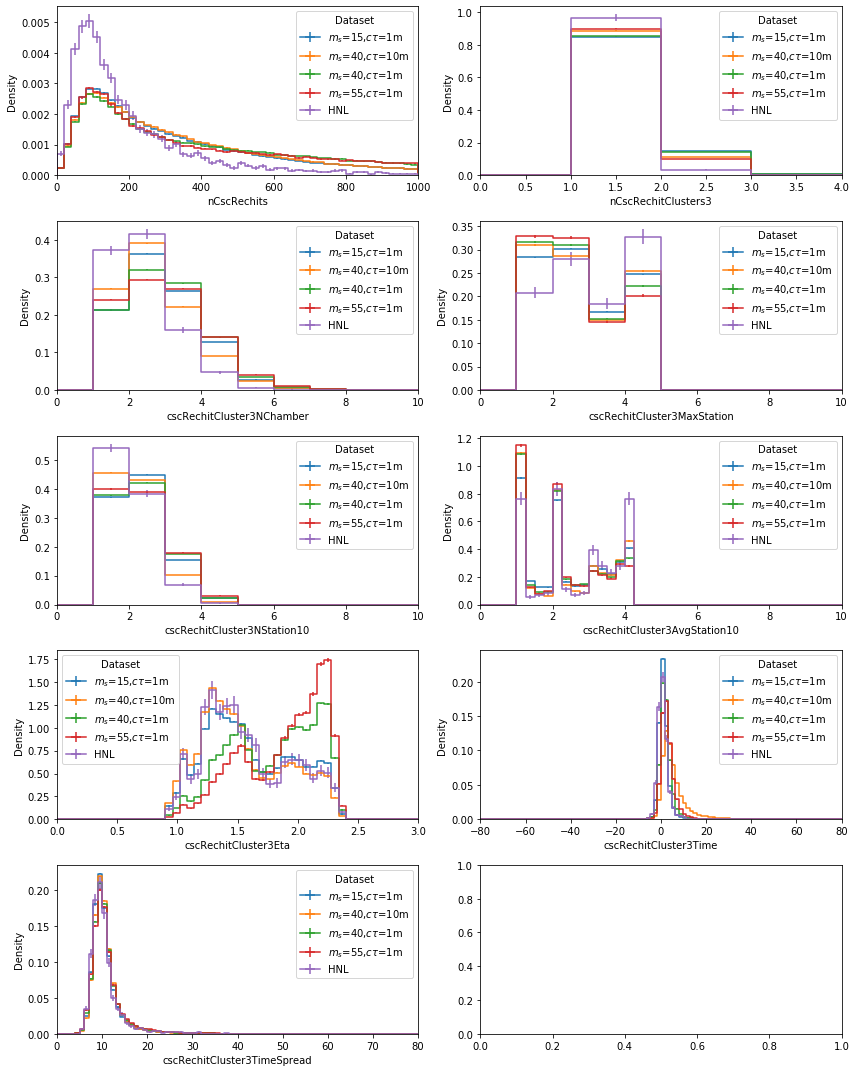

In [5]:

hists = [
    out["nCscRechits"],
    out["nCscRechitClusters3"],
    out['cscRechitCluster3NChamber'],
#     out['cscRechitCluster3MaxChamber'],
    out['cscRechitCluster3MaxStation'],
    out['cscRechitCluster3NStation10'],
    out['cscRechitCluster3AvgStation10'],
    out['cscRechitCluster3Eta'],    
    out['cscRechitCluster3Time'],
    out['cscRechitCluster3TimeSpread'],    
]

ncols=2
nrows=int(np.ceil(len(hists)/ncols))
figsize=(6,3)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs = axs.flatten()

for i,h in enumerate(hists):
    h.label='Density'
    hist.plot1d(h,ax=axs[i], overlay='dataset',density=True,clear=False)

plt.tight_layout()
plt.show()

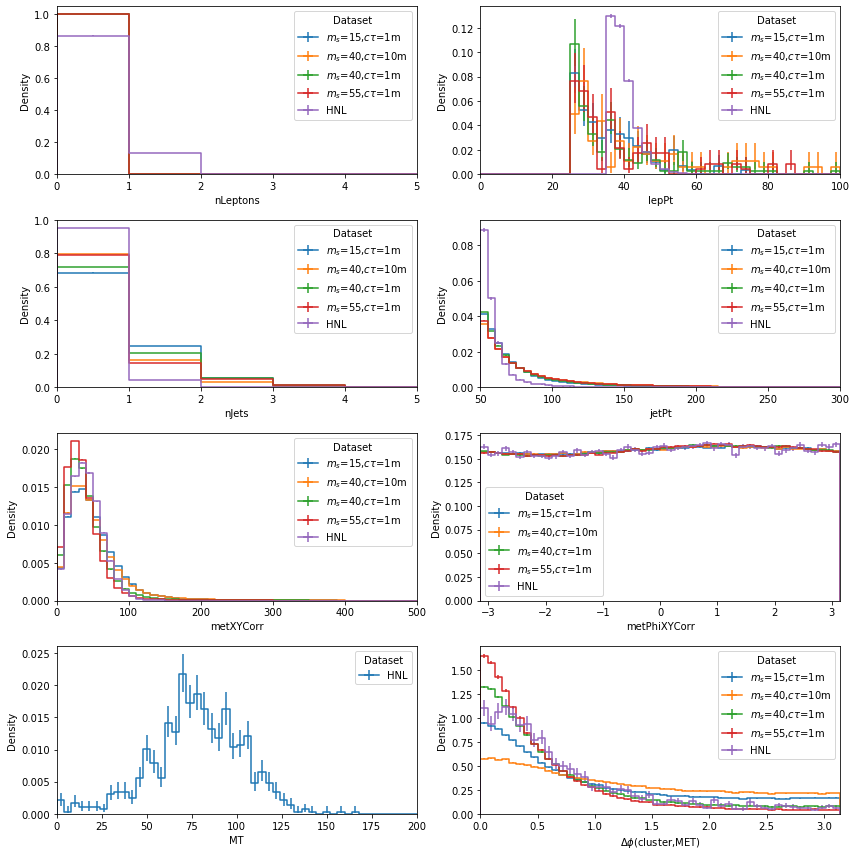

In [8]:
hists = [
    out["nLeptons"],
    out["lepPt"],
    out['nJets'],
    out['jetPt'],
    out['metXYCorr'],
    out['metPhiXYCorr'],    
    out['MT']["HNL"],    
    out['dphi_cluster_MET']
]


ncols=2
nrows=int(np.ceil(len(hists)/ncols))
figsize=(6,3)

fig, axs = plt.subplots(nrows, ncols, squeeze=False,
                        figsize=[ncols*figsize[0],nrows*figsize[1]])
axs = axs.flatten()

for i,h in enumerate(hists):
    h.label='Density'
    hist.plot1d(h,ax=axs[i], overlay='dataset',density=True,clear=False)

plt.tight_layout()

Efficiency in CSC:
('$m_s$=55,$c\\tau$=1m',) 0.019
('$m_s$=40,$c\\tau$=1m',) 0.046
('$m_s$=15,$c\\tau$=1m',) 0.085
('HNL',) 0.014


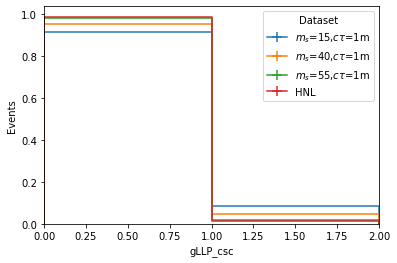

In [58]:
h = out["gLLP_csc"]
ax = hist.plot1d(h, overlay='dataset',density=True,clear=False)
print("Efficiency in CSC:")
for ds,arr in h.values().items():
    print(ds,"{:.3f}".format(arr[1]/np.sum(arr)))